In [1]:
#pereprocessing (option 1)
import cv2
import numpy as np
from skimage import exposure
from scipy.ndimage import interpolation as inter
import os

def orientation_correction(image):
    # Convert to grayscale if not already
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    # Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    if lines is not None:
        # If lines are detected, calculate rotation angle
        angles = []
        for rho, theta in lines[:, 0]:
            angle = np.degrees(theta) - 90
            if angle > 45:
                angle -= 90
            elif angle < -45:
                angle += 90
            angles.append(angle)
        
        # Average angle
        if angles:
            angle = np.mean(angles)
            # Rotate image
            if len(image.shape) == 2:  
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            return inter.rotate(image, angle, reshape=False, mode='nearest')
    
    return image

def resolution_optimization(image, target_dpi=300):
    height, width = image.shape[:2]
    scale = target_dpi / 96  
    new_size = (int(width * scale), int(height * scale))
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return resized_image

def grayscale_conversion(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def binarization(image):
    # Convert to grayscale if not already
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def noise_reduction(image):
    return cv2.medianBlur(image, 3)

def unsharp_masking(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

def normalization(image):
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return normalized_image

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Image could not be loaded from {image_path}")
    
    output_dir = "preprocessedmy"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save original image
    cv2.imwrite(os.path.join(output_dir, "0_original.jpg"), image)
    
    # Step 1: Orientation Correction
    image = orientation_correction(image)
    cv2.imwrite(os.path.join(output_dir, "1_oriented.jpg"), image)
    
    # Convert to 3-channel image if needed
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Step 2: Resolution Optimization
    image = resolution_optimization(image)
    cv2.imwrite(os.path.join(output_dir, "2_resolution_optimized.jpg"), image)
    
    # Step 3: Grayscale Conversion
    image = grayscale_conversion(image)
    cv2.imwrite(os.path.join(output_dir, "3_grayscale.jpg"), image)
    
    # Step 4: Binarization
    image = binarization(image)
    cv2.imwrite(os.path.join(output_dir, "4_binarized.jpg"), image)
    
    # Step 5: Noise Reduction
    image = noise_reduction(image)
    cv2.imwrite(os.path.join(output_dir, "5_noise_reduced.jpg"), image)
    
    # Step 6: Unsharp Masking
    image = unsharp_masking(image)
    cv2.imwrite(os.path.join(output_dir, "6_sharpened.jpg"), image)
    
    # Step 7: Normalization
    image = normalization(image)
    cv2.imwrite(os.path.join(output_dir, "7_normalized.jpg"), image)
    
    return image


input_image = "test.jpeg"
try:
    final_image = preprocess_image(input_image)
    print(f"Image processing completed. Results saved in 'preprocessedmy' folder.")
except Exception as e:
    print(f"Error processing image: {str(e)}")

Error processing image: Image could not be loaded from test.jpeg


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

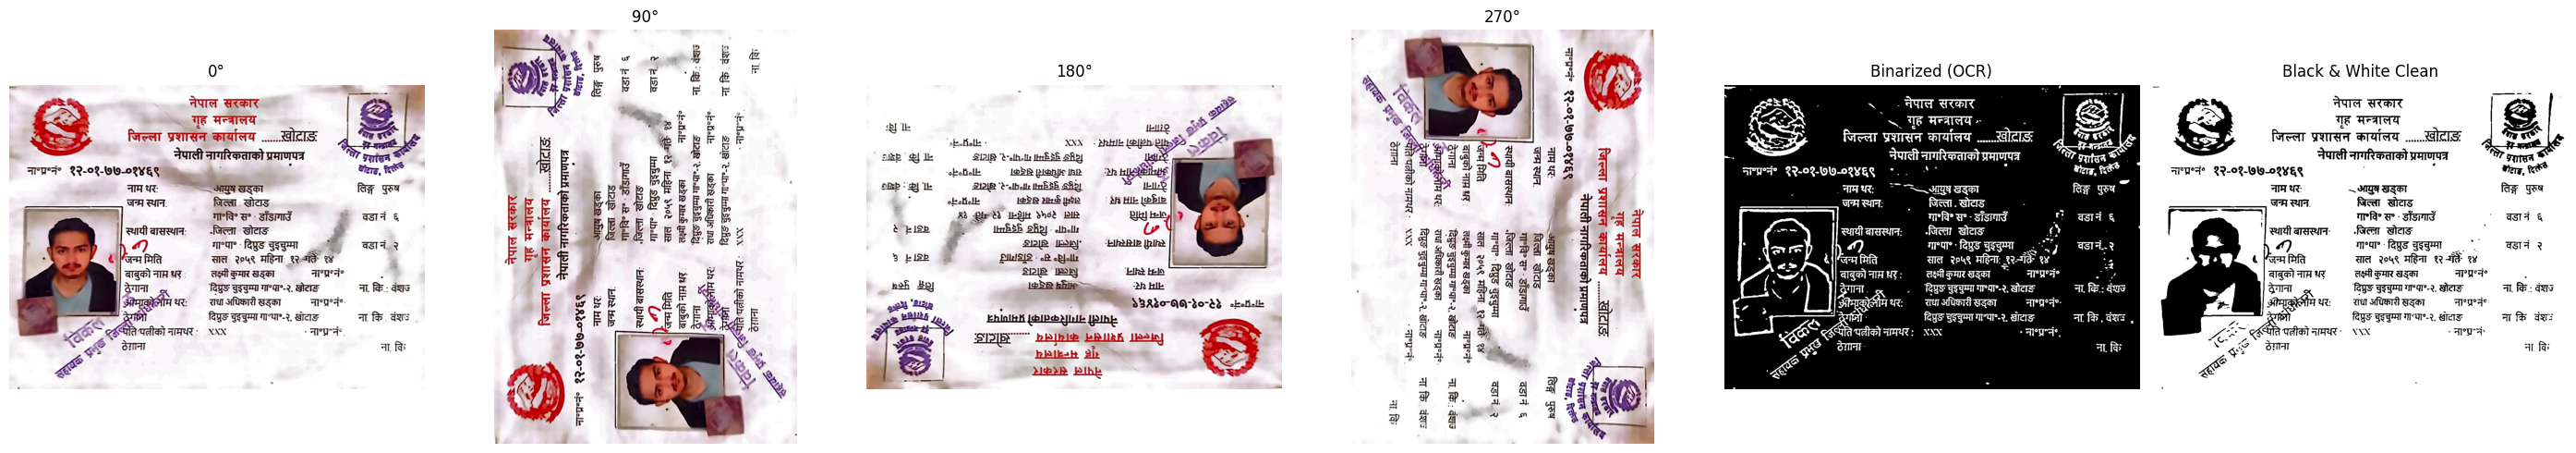

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis

# Load InsightFace face detector (CPU only for portability)
face_app = FaceAnalysis(name="buffalo_l", providers=["CPUExecutionProvider"])
face_app.prepare(ctx_id=0)

# Rotation with smart padding
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos, sin = abs(matrix[0, 0]), abs(matrix[0, 1])
    new_w, new_h = int(h * sin + w * cos), int(h * cos + w * sin)
    matrix[0, 2] += (new_w / 2) - center[0]
    matrix[1, 2] += (new_h / 2) - center[1]
    return cv2.warpAffine(image, matrix, (new_w, new_h), flags=cv2.INTER_LINEAR, borderValue=(255, 255, 255))

# Face confidence scorer
def detect_face_confidence(image):
    faces = face_app.get(image)
    return max((f.det_score for f in faces), default=0)

# Contour crop + auto-zoom and padding
def crop_largest_contour(image, padding=20):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    x1, y1 = max(x - padding, 0), max(y - padding, 0)
    x2, y2 = min(x + w + padding, image.shape[1]), min(y + h + padding, image.shape[0])
    cropped = image[y1:y2, x1:x2]
    # Optional: Add border if too thin for YOLO
    if min(cropped.shape[:2]) < 300:
        cropped = cv2.copyMakeBorder(cropped, 40, 40, 40, 40, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    return cropped

#  Enhancement pipeline: CLAHE + smoothing + unsharp masking
def enhance_image(image):
    # 1. Denoising
    denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

    # 2. CLAHE on LAB lightness channel
    lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(4, 4))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # 3. Bilateral filter
    smooth = cv2.bilateralFilter(enhanced, 5, 50, 50)

    # 4. Unsharp masking for edge clarity
    gaussian = cv2.GaussianBlur(smooth, (0, 0), 2.0)
    sharpened = cv2.addWeighted(smooth, 1.8, gaussian, -0.8, 0)

    return sharpened

#  Visualization helper
def show_results(results, best_angle, bin_output, bw_output):
    results = sorted(results, key=lambda x: x[0])
    fig, axes = plt.subplots(1, 6, figsize=(28, 5))
    for i, (angle, enhanced, _) in enumerate(results):
        axes[i].imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"{angle}°{'' if angle == best_angle else ''}")
        axes[i].axis("off")
    axes[4].imshow(bin_output, cmap="gray")
    axes[4].set_title("Binarized (OCR)")
    axes[4].axis("off")
    axes[5].imshow(bw_output, cmap="gray")
    axes[5].set_title("Black & White Clean")
    axes[5].axis("off")
    plt.tight_layout()
    plt.show()

# Main preprocessor
def process_image_4way(input_path, save_name="best_output", save_dir="preprocessed"):
    os.makedirs(save_dir, exist_ok=True)
    image = cv2.imread(input_path)
    if image is None:
        print(" le not found:", input_path)
        return

    print("Loaded:", input_path)

    angles = [0, 90, 180, 270]
    results = []

    for angle in angles:
        rotated = rotate_image(image, angle)
        cropped = crop_largest_contour(rotated)
        if cropped is None:
            print(f"⚠️ No valid contour at {angle}° — skipped.")
            continue
        enhanced = enhance_image(cropped)
        score = detect_face_confidence(enhanced)
        if angle == 0:
            score += 0.06  #  Boost default upright image
        results.append((angle, enhanced, score))

    if not results:
        print(" No valid result found.")
        return

    # Save rotated + enhanced versions
    for angle, enhanced_img, _ in results:
        cv2.imwrite(os.path.join(save_dir, f"{save_name}_{angle}.jpg"), enhanced_img)

    # Select best one
    best_angle, best_img, best_score = max(results, key=lambda x: x[2])
    print(f" Best angle: {best_angle}° | Score: {best_score:.4f}")

    # Final grayscale for OCR/Binarization
    gray = cv2.cvtColor(best_img, cv2.COLOR_BGR2GRAY)

    # Final binarized (OCR optimized)
    binarized = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 35, 11
    )
    binarized = cv2.morphologyEx(binarized, cv2.MORPH_OPEN,
                                  cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))

    # Final B&W (used in label detection sometimes)
    _, bw_output = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Save final outputs
    cv2.imwrite(os.path.join(save_dir, f"{save_name}_final.jpg"), binarized)
    cv2.imwrite(os.path.join(save_dir, f"{save_name}_final_bw.jpg"), bw_output)

    # 🔍 Show preview
    show_results(results, best_angle, binarized, bw_output)

# Run
process_image_4way("test.jpg")


In [ ]:
import os
import cv2
import json
import re
import hashlib
import numpy as np
from glob import glob
import easyocr
from ultralytics import YOLO
from difflib import get_close_matches

# Load model
YOLO_MODEL = YOLO("lisc.pt")
EASY_OCR = easyocr.Reader(['en'], gpu=False)

# Field mapping
KNOWN_FIELDS = [
    "License Number", "Blood Group", "Name", "Address", "License Office",
    "Date of Birth", "Father/Husband Name", "Citizenship Number",
    "Category", "Passport Number", "Contact Number",
    "Issued Date", "Expiry Date"
]

LABEL_MAPPING = {
    "D.L.No": "License Number", "DL No": "License Number", "DLNo": "License Number",
    "B.G.": "Blood Group", "Blood Group": "Blood Group", "Name": "Name",
    "Address": "Address", "License Office": "License Office", "D.O.B.": "Date of Birth",
    "DOB": "Date of Birth", "F/H Name": "Father/Husband Name", "Father Name": "Father/Husband Name",
    "Citizenship No": "Citizenship Number", "Category": "Category",
    "Passport No": "Passport Number", "Contact No": "Contact Number",
    "D.O.I.": "Issued Date", "D.O.E.": "Expiry Date"
}

LABEL_KEYWORDS = {k.lower(): v for k, v in LABEL_MAPPING.items()}


def clean_text(text):
    text = re.sub(r"[^\w\s\-:/]", "", text)
    return re.sub(r"\s+", " ", text).strip()

def enhance_crop(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(resized, -1, sharpen_kernel)
    return sharpened

def correct_rotation(crop):
    h, w = crop.shape[:2]
    return cv2.rotate(crop, cv2.ROTATE_90_CLOCKWISE) if h > w * 1.3 else crop

def get_crop_hash(crop):
    _, buffer = cv2.imencode('.png', crop)
    return hashlib.md5(buffer).hexdigest()

def extract_text(crop):
    try:
        results = EASY_OCR.readtext(crop, detail=0)
        return clean_text(" ".join(results))
    except:
        return ""

def match_label(text):
    text_lower = text.lower()
    for label in LABEL_KEYWORDS:
        if label in text_lower:
            return LABEL_KEYWORDS[label], text[text_lower.index(label) + len(label):].strip(" :-")
    return None, text

def get_best_field_label(text):
    matches = get_close_matches(text, KNOWN_FIELDS, n=1, cutoff=0.6)
    return matches[0] if matches else "Unknown"

def try_rotations_for_best_label(crop):
    angles = [0, 90, 180, 270]
    for angle in angles:
        rotated_crop = cv2.rotate(crop, {
            0: None,
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle]) if angle != 0 else crop
        text = extract_text(rotated_crop)
        label, value = match_label(text)
        if label:
            return label, value, rotated_crop
    return None, extract_text(crop), crop

def postprocess_value(label, value):
    value = clean_text(value)
    if label in ["Date of Birth", "Issued Date", "Expiry Date"]:
        match = re.search(r"\d{4}[-/]\d{2}[-/]\d{2}|\d{2}[-/]\d{2}[-/]\d{4}", value)
        return match.group(0) if match else value
    if label == "Category":
        return value.replace(" ", "").upper()
    return value


seen_hashes = set()
final_combined = {}

def process_image(img_path, output_dir):
    global final_combined
    global_best = {}
    image = cv2.imread(img_path)
    if image is None:
        print(f" Failed to load {img_path}")
        return

    file_name = os.path.basename(img_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated = image.copy()
    crop_dir = os.path.join(output_dir, "crops")
    os.makedirs(crop_dir, exist_ok=True)

    try:
        results = YOLO_MODEL.predict(img_rgb, conf=0.5, max_det=40, device="cpu", verbose=False)
    except Exception as e:
        print(f" YOLO error: {e}")
        return

    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            w_pad, h_pad = int(0.02 * (x2 - x1)), int(0.02 * (y2 - y1))
            x1, y1 = max(0, x1 - w_pad), max(0, y1 - h_pad)
            x2, y2 = min(image.shape[1], x2 + w_pad), min(image.shape[0], y2 + h_pad)

            crop = image[y1:y2, x1:x2]
            crop = correct_rotation(crop)
            crop = enhance_crop(crop)

            hash_key = get_crop_hash(crop)
            if hash_key in seen_hashes:
                continue
            seen_hashes.add(hash_key)

            ocr_text = extract_text(crop)
            label, raw_value = match_label(ocr_text)

            if not label:
                label, raw_value, crop = try_rotations_for_best_label(crop)
                if not label:
                    label = get_best_field_label(ocr_text[:25])
                    raw_value = ocr_text

            value = postprocess_value(label, raw_value)
            crop_name = f"{os.path.splitext(file_name)[0]}_{label}_{x1}_{y1}.jpg"
            crop_path = os.path.join(crop_dir, crop_name)
            cv2.imwrite(crop_path, crop)

            field_result = {
                "ocr_text": value,
                "confidence": round(float(confs[i]), 3),
                "crop_image_path": crop_path,
                "source_image": file_name
            }

            # Always pick higher confidence for same label
            if label in global_best:
                if field_result["confidence"] > global_best[label]["confidence"]:
                    global_best[label] = field_result
            else:
                global_best[label] = field_result

            if label in final_combined:
                if field_result["confidence"] > final_combined[label]["confidence"]:
                    final_combined[label] = field_result
            else:
                final_combined[label] = field_result

            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    out_path = os.path.join(output_dir, f"annotated_{file_name}")
    cv2.imwrite(out_path, annotated)

    with open(os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}_fields.json"), "w", encoding="utf-8") as f:
        json.dump(global_best, f, indent=4, ensure_ascii=False)



def main():
    input_dir = "preprocessed"
    output_dir = "ocr_results"
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "crops"), exist_ok=True)

    image_paths = glob(os.path.join(input_dir, "*.jpg")) + \
                  glob(os.path.join(input_dir, "*.jpeg")) + \
                  glob(os.path.join(input_dir, "*.png"))

    for img in image_paths:
        process_image(img, output_dir)

    with open(os.path.join(output_dir, "final_combined.json"), "w", encoding="utf-8") as f:
        json.dump(final_combined, f, indent=4, ensure_ascii=False)

if __name__ == "__main__":
    main()


Using CPU. Note: This module is much faster with a GPU.


In [4]:
import os
import cv2
import json
import logging
import numpy as np
from glob import glob
from ultralytics import YOLO
import pytesseract
import easyocr
from fuzzywuzzy import fuzz, process
import hashlib

#  Suppress unnecessary logs
logging.getLogger().setLevel(logging.ERROR)

#  Load YOLOv8 and EasyOCR
model = YOLO("best.pt")
easyocr_reader = easyocr.Reader(['ne', 'en'], gpu=False)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

#  Target fields for Nepali Citizenship documents
KNOWN_FIELDS = [
    "Name", "Father's Name", "Mother's Name", "Date of Birth",
    "Place of Birth", "Permanent Address", "Temporary Address",
    "Citizenship Number", "Issued District", "Gender",
    "Spouse Name", "Grandfather's Name", "Issued Date"
]

# 🇳🇵 Nepali + English hints for citizenship field recognition
NEPALI_HINTS = {
    "नाम": "Name", "नाउँ": "Name",
    "बुबाको नाम": "Father's Name", "पिताको नाम": "Father's Name",
    "आमाको नाम": "Mother's Name", "बाजेको नाम": "Grandfather's Name",
    "पति": "Spouse Name", "पत्नी": "Spouse Name",
    "लिङ्ग": "Gender", "पुरुष": "Gender", "महिला": "Gender",
    "स्थायी": "Permanent Address", "अस्थायी": "Temporary Address",
    "ठेगाना": "Permanent Address", "जन्म": "Date of Birth",
    "जन्म स्थान": "Place of Birth", "मिति": "Date of Birth",
    "ना.प्र.नं": "Citizenship Number", "ना.प्र.सं": "Citizenship Number",
    "जारी जिल्ला": "Issued District", "जारी मिति": "Issued Date"
}

#  Clean OCR text
def clean_text(text):
    text = ''.join(ch for ch in text if ch.isalnum() or ch.isspace() or ch in "-:/")
    return text.strip()

#  Smart field classification from OCR
def get_best_field_match(text):
    if not text.strip():
        return "Unknown"
    for hint, field in NEPALI_HINTS.items():
        if hint.lower() in text.lower():
            return field
    words = text.lower().split()
    for word in words:
        for hint, field in NEPALI_HINTS.items():
            if word in hint.lower():
                return field
    best, score = process.extractOne(text.lower(), KNOWN_FIELDS, scorer=fuzz.partial_ratio)
    return best if score > 60 else "Unknown"

#  OCR with fallback: Tesseract (nep-fuse-2, nep) → EasyOCR
def extract_text(image_crop):
    for lang in ["nep-fuse-2", "nep"]:
        try:
            raw = pytesseract.image_to_string(image_crop, lang=lang).strip()
            text = clean_text(raw)
            if len(text) >= 2:
                return text, lang
        except:
            continue
    try:
        results = easyocr_reader.readtext(image_crop)
        text = clean_text(" ".join(res[1] for res in results))
        if len(text) >= 2:
            return text, "easyocr"
    except:
        pass
    return "", "none"

#  Rotate if needed (OSD method)
def auto_rotate(image):
    try:
        osd = pytesseract.image_to_osd(image)
        angle = int([l for l in osd.split("\n") if "Rotate" in l][0].split(":")[-1])
        if angle:
            code = {90: cv2.ROTATE_90_CLOCKWISE, 180: cv2.ROTATE_180, 270: cv2.ROTATE_90_COUNTERCLOCKWISE}.get(angle)
            if code:
                image = cv2.rotate(image, code)
        return image, angle
    except:
        return image, 0

# Crop enhancer
def enhance_crop(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(resized, -1, sharpen_kernel)
    return sharpened

# Check for better label on rotations
def try_rotations_for_best_label(crop):
    angles = [0, 90, 180, 270]
    for angle in angles:
        rotated_crop = cv2.rotate(crop, {
            0: None,
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle]) if angle != 0 else crop
        text = extract_text(rotated_crop)[0]
        field = get_best_field_match(text)
        if field != "Unknown":
            return field, text, rotated_crop
    return "Unknown", extract_text(crop)[0], crop

# Process individual image
final_combined = {}

def process_image(path, output_dir):
    global final_combined
    image = cv2.imread(path)
    if image is None:
        print(f"Can't read {path}")
        return

    image, rotation = auto_rotate(image)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated = image.copy()
    image_name = os.path.basename(path)

    result_json = {
        "file": image_name,
        "rotation": rotation,
        "size": image.shape[:2],
        "detections": []
    }

    try:
        results = model.predict(img_rgb, conf=0.6, max_det=30, device="cpu", verbose=False)
    except Exception as e:
        print(f"YOLO error: {e}")
        return

    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            w_pad, h_pad = int(0.02 * (x2 - x1)), int(0.02 * (y2 - y1))
            x1, y1 = max(0, x1 - w_pad), max(0, y1 - h_pad)
            x2, y2 = min(image.shape[1], x2 + w_pad), min(image.shape[0], y2 + h_pad)

            crop = image[y1:y2, x1:x2]
            crop = enhance_crop(crop)
            field, text, crop = try_rotations_for_best_label(crop)
            conf = float(confs[i])

            result_json["detections"].append({
                "field": field,
                "ocr_text": text,
                "ocr_lang": "nep",
                "confidence": round(conf, 3),
                "box": [x1, y1, x2, y2]
            })

            if field not in final_combined or conf > final_combined[field]["confidence"]:
                final_combined[field] = {
                    "text": text,
                    "confidence": round(conf, 3),
                    "source_image": image_name,
                    "box": [x1, y1, x2, y2]
                }

            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, field, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    out_img = os.path.join(output_dir, f"annotated_{image_name}")
    out_json = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}.json")
    cv2.imwrite(out_img, annotated)
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(result_json, f, indent=4, ensure_ascii=False)

    print(f" Saved: {image_name}")

def main():
    input_dir = "preprocessed"
    output_dir = "ocr_results"
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "crops"), exist_ok=True)

    files = glob(os.path.join(input_dir, "*.jpg")) + glob(os.path.join(input_dir, "*.jpeg")) + glob(os.path.join(input_dir, "*.png"))
    for f in files:
        process_image(f, output_dir)

    with open(os.path.join(output_dir, "final_combined.json"), "w", encoding="utf-8") as f:
        json.dump(final_combined, f, indent=4, ensure_ascii=False)

if __name__ == "__main__":
    main()

 Saved: best_output_0.jpg
 Saved: best_output_180.jpg
 Saved: best_output_270.jpg
 Saved: best_output_90.jpg
 Saved: best_output_final.jpg
 Saved: best_output_final_bw.jpg


In [5]:
import os
import cv2
import json
import logging
import numpy as np
from glob import glob
from ultralytics import YOLO
import pytesseract
import easyocr
from fuzzywuzzy import fuzz, process
import hashlib

#  Suppress unnecessary logs
logging.getLogger().setLevel(logging.ERROR)

#  Load YOLOv8 and EasyOCR
model = YOLO("best.pt")
easyocr_reader = easyocr.Reader(['ne', 'en'], gpu=False)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

#  Target fields for Nepali Citizenship documents
KNOWN_FIELDS = [
    "Name", "Father's Name", "Mother's Name", "Date of Birth",
    "Place of Birth", "Permanent Address", "Temporary Address",
    "Citizenship Number", "Issued District", "Gender",
    "Spouse Name", "Grandfather's Name", "Issued Date"
]

# 🇳🇵 Nepali + English hints for citizenship field recognition
NEPALI_HINTS = {
    "नाम": "Name", "नाउँ": "Name",
    "बुबाको नाम": "Father's Name", "पिताको नाम": "Father's Name",
    "आमाको नाम": "Mother's Name", "बाजेको नाम": "Grandfather's Name",
    "पति": "Spouse Name", "पत्नी": "Spouse Name",
    "लिङ्ग": "Gender", "पुरुष": "Gender", "महिला": "Gender",
    "स्थायी": "Permanent Address", "अस्थायी": "Temporary Address",
    "ठेगाना": "Permanent Address", "जन्म": "Date of Birth",
    "जन्म स्थान": "Place of Birth", "मिति": "Date of Birth",
    "ना.प्र.नं": "Citizenship Number", "ना.प्र.सं": "Citizenship Number",
    "जारी जिल्ला": "Issued District", "जारी मिति": "Issued Date"
}

#  Clean OCR text
def clean_text(text):
    text = ''.join(ch for ch in text if ch.isalnum() or ch.isspace() or ch in "-:/")
    return text.strip()

#  Smart field classification from OCR
def get_best_field_match(text):
    if not text.strip():
        return "Unknown"
    for hint, field in NEPALI_HINTS.items():
        if hint.lower() in text.lower():
            return field
    words = text.lower().split()
    for word in words:
        for hint, field in NEPALI_HINTS.items():
            if word in hint.lower():
                return field
    best, score = process.extractOne(text.lower(), KNOWN_FIELDS, scorer=fuzz.partial_ratio)
    return best if score > 60 else "Unknown"

#  OCR with fallback: Tesseract (nep-fuse-2, nep) → EasyOCR
def extract_text(image_crop):
    for lang in ["nep-fuse-2", "nep"]:
        try:
            raw = pytesseract.image_to_string(image_crop, lang=lang).strip()
            text = clean_text(raw)
            if len(text) >= 2:
                return text, lang
        except:
            continue
    try:
        results = easyocr_reader.readtext(image_crop)
        text = clean_text(" ".join(res[1] for res in results))
        if len(text) >= 2:
            return text, "easyocr"
    except:
        pass
    return "", "none"

#  Rotate if needed (OSD method)
def auto_rotate(image):
    try:
        osd = pytesseract.image_to_osd(image)
        angle = int([l for l in osd.split("\n") if "Rotate" in l][0].split(":")[-1])
        if angle:
            code = {90: cv2.ROTATE_90_CLOCKWISE, 180: cv2.ROTATE_180, 270: cv2.ROTATE_90_COUNTERCLOCKWISE}.get(angle)
            if code:
                image = cv2.rotate(image, code)
        return image, angle
    except:
        return image, 0

# Crop enhancer
def enhance_crop(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(resized, -1, sharpen_kernel)
    return sharpened

# Check for better label on rotations
def try_rotations_for_best_label(crop):
    angles = [0, 90, 180, 270]
    for angle in angles:
        rotated_crop = cv2.rotate(crop, {
            0: None,
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle]) if angle != 0 else crop
        text = extract_text(rotated_crop)[0]
        field = get_best_field_match(text)
        if field != "Unknown":
            return field, text, rotated_crop
    return "Unknown", extract_text(crop)[0], crop

# Process individual image
final_combined = {}

def process_image(path, output_dir):
    global final_combined
    image = cv2.imread(path)
    if image is None:
        print(f"Can't read {path}")
        return

    image, rotation = auto_rotate(image)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated = image.copy()
    image_name = os.path.basename(path)

    result_json = {
        "file": image_name,
        "rotation": rotation,
        "size": image.shape[:2],
        "detections": []
    }

    try:
        results = model.predict(img_rgb, conf=0.6, max_det=30, device="cpu", verbose=False)
    except Exception as e:
        print(f"YOLO error: {e}")
        return

    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            w_pad, h_pad = int(0.02 * (x2 - x1)), int(0.02 * (y2 - y1))
            x1, y1 = max(0, x1 - w_pad), max(0, y1 - h_pad)
            x2, y2 = min(image.shape[1], x2 + w_pad), min(image.shape[0], y2 + h_pad)

            crop = image[y1:y2, x1:x2]
            crop = enhance_crop(crop)
            field, text, crop = try_rotations_for_best_label(crop)
            conf = float(confs[i])

            result_json["detections"].append({
                "field": field,
                "ocr_text": text,
                "ocr_lang": "nep",
                "confidence": round(conf, 3),
                "box": [x1, y1, x2, y2]
            })

            if field not in final_combined or conf > final_combined[field]["confidence"]:
                final_combined[field] = {
                    "text": text,
                    "confidence": round(conf, 3),
                    "source_image": image_name,
                    "box": [x1, y1, x2, y2]
                }

            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, field, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    out_img = os.path.join(output_dir, f"annotated_{image_name}")
    out_json = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}.json")
    cv2.imwrite(out_img, annotated)
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(result_json, f, indent=4, ensure_ascii=False)

    print(f" Saved: {image_name}")

def main():
    input_dir = "preprocessed"
    output_dir = "ocr_results"
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "crops"), exist_ok=True)

    files = glob(os.path.join(input_dir, "*.jpg")) + glob(os.path.join(input_dir, "*.jpeg")) + glob(os.path.join(input_dir, "*.png"))
    for f in files:
        process_image(f, output_dir)

    with open(os.path.join(output_dir, "final_combined.json"), "w", encoding="utf-8") as f:
        json.dump(final_combined, f, indent=4, ensure_ascii=False)

if __name__ == "__main__":
    main()

 Saved: best_output_0.jpg
 Saved: best_output_180.jpg
 Saved: best_output_270.jpg
 Saved: best_output_90.jpg
 Saved: best_output_final.jpg
 Saved: best_output_final_bw.jpg


In [6]:
import os
import cv2
import json
import logging
import numpy as np
from glob import glob
from ultralytics import YOLO
import pytesseract
import easyocr
from fuzzywuzzy import fuzz, process

# 🔇 Suppress unnecessary logs
logging.getLogger().setLevel(logging.ERROR)

# 📦 Load YOLOv8 and EasyOCR
model = YOLO("best.pt")  # replace with your custom model path
easyocr_reader = easyocr.Reader(['ne', 'en'], gpu=False)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 🎯 Target fields
KNOWN_FIELDS = [
    "Name", "Father's Name", "Mother's Name", "Date of Birth",
    "Address", "Citizenship Number", "Issued District", "Gender"
]

# 🇳🇵 Nepali hints for field recognition
NEPALI_FIELD_HINTS = {
    "नाम": "Name",
    "नाउँ": "Name",
    "पिता": "Father's Name",
    "बुबा": "Father's Name",
    "आमा": "Mother's Name",
    "जन्म": "Date of Birth",
    "मिति": "Date of Birth",
    "ठेगाना": "Address",
    "नागरिकता नं": "Citizenship Number",
    "नागरिकता": "Citizenship Number",
    "जारी": "Issued District",
    "जिल्ला": "Issued District",
    "लिङ्ग": "Gender",
    "महिला": "Gender",
    "पुरुष": "Gender"
}

# 🧹 Clean text: removes unwanted chars
def clean_text(text):
    text = ''.join(ch for ch in text if ch.isalnum() or ch.isspace())
    return text.strip()

# 🧠 Best NLP field matcher using Nepali hints + fuzzy English
def get_best_field_match(text):
    if not text.strip():
        return "Unknown"
    for nep, eng in NEPALI_FIELD_HINTS.items():
        if nep in text:
            return eng
    best_match, score = process.extractOne(text.lower(), KNOWN_FIELDS, scorer=fuzz.partial_ratio)
    return best_match if score > 60 else "Unknown"

# 🧠 OCR fallback: Tesseract (custom → default) → EasyOCR
def extract_text_full_fallback(image_crop):
    for lang in ["nep-fuse-2", "nep"]:
        try:
            raw = pytesseract.image_to_string(image_crop, lang=lang).strip()
            text = clean_text(raw)
            if len(text) >= 2:
                return text, lang
        except:
            continue
    try:
        results = easyocr_reader.readtext(image_crop)
        easy_text = " ".join([res[1] for res in results])
        text = clean_text(easy_text)
        if len(text) >= 2:
            return text, "easyocr"
    except:
        pass
    return "", "none"

# 🔄 Auto-rotate via Tesseract OSD
def auto_rotate_image(image):
    try:
        osd = pytesseract.image_to_osd(image)
        rotate_angle = int([line for line in osd.split("\n") if "Rotate" in line][0].split(":")[-1])
        if rotate_angle != 0:
            code = {
                90: cv2.ROTATE_90_CLOCKWISE,
                180: cv2.ROTATE_180,
                270: cv2.ROTATE_90_COUNTERCLOCKWISE
            }.get(rotate_angle)
            if code:
                image = cv2.rotate(image, code)
        return image, rotate_angle
    except:
        return image, 0

# 🧠 Main image processing logic
def process_image(path, output_folder):
    img = cv2.imread(path)
    if img is None:
        print(f"❌ Cannot read image: {path}")
        return

    img, rotation = auto_rotate_image(img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    annotated = img.copy()

    json_data = {
        "file_name": os.path.basename(path),
        "rotation_angle": rotation,
        "image_size": {"height": img.shape[0], "width": img.shape[1]},
        "detections": []
    }

    try:
        results = model.predict(img_rgb, conf=0.6, max_det=20, device="cpu", verbose=False)
    except Exception as e:
        print(f"⚠️ YOLO detection failed: {e}")
        return

    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            class_id = int(classes[i])
            raw_label = model.names.get(class_id, f"class_{class_id}")

            crop = img[y1:y2, x1:x2]
            ocr_text, lang_used = extract_text_full_fallback(crop)
            field_name = get_best_field_match(ocr_text or raw_label)

            # Annotate
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, field_name, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Add to JSON
            json_data["detections"].append({
                "field_name": field_name,
                "raw_label": raw_label,
                "confidence": round(float(confs[i]), 3),
                "bounding_box": {"x1": x1, "y1": y1, "x2": x2, "y2": y2},
                "ocr_text": ocr_text,
                "ocr_lang_used": lang_used
            })

    # Save outputs
    image_name = os.path.basename(path)
    cv2.imwrite(os.path.join(output_folder, f"annotated_{image_name}"), annotated)
    with open(os.path.join(output_folder, f"{os.path.splitext(image_name)[0]}.json"), "w", encoding="utf-8") as f:
        json.dump(json_data, f, indent=4, ensure_ascii=False)

    print(f"✅ Done: {image_name} | JSON + annotated image saved.")

# 🧪 Runner
def main():
    image_folder = "preprocessed"
    output_folder = "ocr_results"
    os.makedirs(image_folder, exist_ok=True)
    os.makedirs(output_folder, exist_ok=True)

    image_paths = glob(os.path.join(image_folder, "*.jpg")) + \
                  glob(os.path.join(image_folder, "*.jpeg")) + \
                  glob(os.path.join(image_folder, "*.png"))

    if not image_paths:
        print("⚠️ No images found in 'preprocessed' folder.")
        return

    for path in image_paths:
        print(f"🔍 Processing: {os.path.basename(path)}")
        process_image(path, output_folder)

if __name__ == "__main__":
    main()


🔍 Processing: best_output_0.jpg
✅ Done: best_output_0.jpg | JSON + annotated image saved.
🔍 Processing: best_output_180.jpg
✅ Done: best_output_180.jpg | JSON + annotated image saved.
🔍 Processing: best_output_270.jpg
✅ Done: best_output_270.jpg | JSON + annotated image saved.
🔍 Processing: best_output_90.jpg
✅ Done: best_output_90.jpg | JSON + annotated image saved.
🔍 Processing: best_output_final.jpg
✅ Done: best_output_final.jpg | JSON + annotated image saved.
🔍 Processing: best_output_final_bw.jpg
✅ Done: best_output_final_bw.jpg | JSON + annotated image saved.


In [ ]:
pip install ultralytics opencv-python easyocr pytesseract fuzzywuzzy python-Levenshtein


In [ ]:
import os
import cv2
import json
import logging
import numpy as np
from glob import glob
import re
from ultralytics import YOLO
from fuzzywuzzy import fuzz, process
from paddleocr import PaddleOCR
import easyocr
import pytesseract
import dateutil.parser

# 🔇 Suppress logs
logging.getLogger().setLevel(logging.ERROR)

# ✅ NLP Config
CANDIDATE_FIELDS = [
    "License Number", "Name", "Date of Birth", "Issued Date",
    "Expiry Date", "Category", "Blood Group", "Address", "Citizenship Number"
]

FIELD_PATTERNS = {
    "License Number": r"\d{2,3}/\d{5,7}",
    "Date of Birth": r"\d{4}-\d{2}-\d{2}|\d{2}/\d{2}/\d{4}",
    "Issued Date": r"(issued|प्रदत्त)[\s:]*\d{4}-\d{2}-\d{2}",
    "Expiry Date": r"(expiry|expire)[\s:]*\d{4}-\d{2}-\d{2}",
    "Blood Group": r"\b[ABO]{1,2}[+-]\b",
    "Category": r"\b[A-Z]{1,3}\b",
    "Citizenship Number": r"\d{6,10}"
}

def clean_ocr_text(text):
    return ''.join(ch for ch in text if ch.isalnum() or ch.isspace()).strip()

def classify_field(text):
    if not text.strip():
        return "Unknown"
    for field, pattern in FIELD_PATTERNS.items():
        if re.search(pattern, text, re.IGNORECASE):
            return field
    best_match, score = process.extractOne(text.lower(), CANDIDATE_FIELDS, scorer=fuzz.partial_ratio)
    return best_match if score > 70 else "Unknown"

def nlp_postprocess_field(field_name, value):
    value = value.strip()
    if field_name == "Name":
        value = " ".join([w.capitalize() for w in value.split() if w.isalpha()])
    elif field_name in ["Date of Birth", "Issued Date", "Expiry Date"]:
        try:
            parsed = dateutil.parser.parse(value, dayfirst=True)
            value = parsed.strftime("%Y-%m-%d")
        except:
            pass
    elif field_name == "License Number":
        if re.match(r"^\d{6,}$", value):
            value = value[:3] + "/" + value[3:]
        value = value.replace(" ", "")
    elif field_name == "Blood Group":
        match = re.search(r"[ABO]{1,2}[+-]", value.upper())
        if match:
            value = match.group()
    elif field_name == "Category":
        value = value.replace(" ", "").upper()
    elif field_name == "Address":
        value = re.sub(r"\s+", " ", value)
    return value

# 🔍 OCR Engines
ocr_paddle = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=False)
ocr_easy = easyocr.Reader(['en'], gpu=False)

def extract_text_smart(image):
    try:
        # 1. PaddleOCR
        result = ocr_paddle.ocr(image, cls=True)
        text_paddle = " ".join([line[1][0] for line in result[0]]).strip()
        text_paddle = clean_ocr_text(text_paddle)
        if len(text_paddle) > 2:
            return text_paddle, "paddleocr"

        # 2. EasyOCR
        text_easy = " ".join(ocr_easy.readtext(image, detail=0)).strip()
        text_easy = clean_ocr_text(text_easy)
        if len(text_easy) > 2:
            return text_easy, "easyocr"

        # 3. Tesseract
        text_tess = pytesseract.image_to_string(image, lang="eng").strip()
        text_tess = clean_ocr_text(text_tess)
        if len(text_tess) > 2:
            return text_tess, "tesseract"

    except Exception as e:
        print(f"❌ OCR failed: {e}")
    return "UNREADABLE", "none"

# 🚀 YOLOv8 Model
os.environ["CUDA_VISIBLE_DEVICES"] = ""
model = YOLO("lisc.pt")  # Replace with your trained license model

def process_image(path, output_folder):
    img = cv2.imread(path)
    if img is None:
        print(f"❌ Cannot read image: {path}")
        return None

    file_name = os.path.basename(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    annotated = img.copy()

    json_result = {
        "file_name": file_name,
        "image_size": {"height": img.shape[0], "width": img.shape[1]},
        "detections": []
    }

    try:
        results = model.predict(img_rgb, conf=0.5, max_det=20, device="cpu", verbose=False)
    except Exception as e:
        print(f"❌ YOLO failed: {e}")
        return None

    detected_fields = set()

    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            crop = img[y1:y2, x1:x2]
            ocr_text, ocr_method = extract_text_smart(crop)
            field_name = classify_field(ocr_text)
            ocr_text = nlp_postprocess_field(field_name, ocr_text)

            detected_fields.add(field_name)

            confidence = float(confs[i])
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, field_name, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            json_result["detections"].append({
                "field_name": field_name,
                "confidence": round(confidence, 3),
                "bounding_box": {"x1": x1, "y1": y1, "x2": x2, "y2": y2},
                "ocr_text": ocr_text,
                "ocr_method": ocr_method,
                "source_image": file_name
            })

    # 🔁 Full-image OCR fallback
    missing_fields = set(CANDIDATE_FIELDS) - detected_fields
    if missing_fields:
        print(f"🔁 Fallback OCR for: {missing_fields}")
        try:
            full_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            full_text_paddle = " ".join([line[1][0] for line in ocr_paddle.ocr(full_gray, cls=True)[0]])
            full_text_easy = " ".join(ocr_easy.readtext(full_gray, detail=0))
            full_text = clean_ocr_text(full_text_paddle + " " + full_text_easy)

            for field in missing_fields:
                pattern = FIELD_PATTERNS.get(field)
                if pattern:
                    match = re.search(pattern, full_text)
                    if match:
                        clean_val = nlp_postprocess_field(field, match.group())
                        json_result["detections"].append({
                            "field_name": field,
                            "confidence": 0.50,
                            "bounding_box": None,
                            "ocr_text": clean_val,
                            "ocr_method": "full_ocr_fallback",
                            "source_image": file_name
                        })
        except Exception as e:
            print(f"❌ Fallback OCR error: {e}")

    # Save outputs
    cv2.imwrite(os.path.join(output_folder, f"annotated_{file_name}"), annotated)
    with open(os.path.join(output_folder, f"{os.path.splitext(file_name)[0]}.json"), "w", encoding="utf-8") as f:
        json.dump(json_result, f, indent=4, ensure_ascii=False)

    print(f"✅ Processed: {file_name}")
    return json_result

# 📦 Combine JSONs by best confidence
def combine_json_files(output_folder):
    all_json = glob(os.path.join(output_folder, "*.json"))
    best_fields = {}

    for jf in all_json:
        with open(jf, "r", encoding="utf-8") as f:
            data = json.load(f)
            for det in data.get("detections", []):
                field = det["field_name"]
                if field not in best_fields or det["confidence"] > best_fields[field]["confidence"]:
                    best_fields[field] = {
                        "ocr_text": det["ocr_text"],
                        "confidence": det["confidence"],
                        "ocr_method": det["ocr_method"],
                        "bounding_box": det["bounding_box"],
                        "source_image": det["source_image"]
                    }

    combined = {
        "fields": best_fields,
        "source_images": list(set(d["source_image"] for d in best_fields.values()))
    }

    with open(os.path.join(output_folder, "main_combined.json"), "w", encoding="utf-8") as f:
        json.dump(combined, f, indent=4, ensure_ascii=False)
    print("📦 Final combined JSON saved.")

# 🎯 Entry
def main():
    input_folder = "preprocessed"
    output_folder = "ocr_results"
    os.makedirs(output_folder, exist_ok=True)

    image_paths = glob(os.path.join(input_folder, "*.jpg")) + \
                  glob(os.path.join(input_folder, "*.jpeg")) + \
                  glob(os.path.join(input_folder, "*.png"))

    if not image_paths:
        print("⚠️ No input images found.")
        return

    for img_path in image_paths:
        process_image(img_path, output_folder)

    combine_json_files(output_folder)

if __name__ == "__main__":
    main()


In [ ]:
import os
import json
import string as st
import cv2
import pytesseract
from passporteye import read_mrz
from dateutil import parser
import warnings

warnings.filterwarnings('ignore')

# Load country codes
with open('country_codess.json', 'r', encoding='utf-8') as f:
    country_codes = json.load(f)

# ---------- Utility Functions ----------

def parse_date(string):
    try:
        date = parser.parse(string, yearfirst=True).date()
        return date.strftime('%d/%m/%Y')
    except Exception:
        return "Invalid Date"

def clean(text):
    return ''.join(i for i in text if i.isalnum()).upper()

def get_country_name(code):
    code = code.upper()
    for country in country_codes:
        if country['alpha-3'] == code:
            return country['name'].upper()
    return code

def get_sex(code):
    code = code.upper()
    if code in ['M', 'F']:
        return code
    if code == '0':  # common OCR misread
        return 'M'
    return 'UNKNOWN'

def print_data(data):
    for key in data:
        label = key.replace('_', ' ').capitalize()
        print(f'{label:<20} : {data[key]}')

# ---------- Main Extraction Function ----------

def get_data(img_path):
    user_info = {}

    # Extract MRZ
    mrz = read_mrz(img_path, save_roi=True)
    if not mrz:
        print(f'⚠️ MRZ not found in image: {img_path}')
        return None

    # Extract MRZ image directly from memory
    mrz_img = mrz.aux['roi']

    # Preprocess MRZ image for Tesseract
    mrz_gray = cv2.cvtColor(mrz_img, cv2.COLOR_RGB2GRAY)
    mrz_resized = cv2.resize(mrz_gray, (1100, 140))
    mrz_thresh = cv2.adaptiveThreshold(mrz_resized, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Tesseract Config for MRZ
    custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789<'
    ocr_result = pytesseract.image_to_string(mrz_thresh, config=custom_config).splitlines()
    code = [line.strip() for line in ocr_result if line.strip()]

    print("🧾 Raw MRZ OCR Output:")
    for line in code:
        print(">>", line)

    if len(code) < 2:
        print("⚠️ OCR failed to extract both MRZ lines.")
        return None

    a = code[0].upper().strip().ljust(44, '<')[:44]
    b = code[1].upper().strip().ljust(44, '<')[:44]

    try:
        surname, names = a[5:44].split('<<', 1) if '<<' in a[5:44] else (a[5:44], '')

        user_info['name'] = names.replace('<', ' ').strip().upper()
        user_info['surname'] = surname.replace('<', ' ').strip().upper()
        user_info['sex'] = get_sex(clean(b[20]))
        user_info['date_of_birth'] = parse_date(b[13:19])
        user_info['nationality'] = get_country_name(clean(b[10:13]))
        user_info['passport_type'] = clean(a[0:2])
        user_info['passport_number'] = clean(b[0:9])
        user_info['issuing_country'] = get_country_name(clean(a[2:5]))
        user_info['expiration_date'] = parse_date(b[21:27])
        user_info['personal_number'] = clean(b[28:42])
    except Exception as e:
        print(f"❌ Error parsing MRZ: {e}")
        user_info['error'] = str(e)

    return user_info

# ---------- Run Extraction ----------

if __name__ == "__main__":
    img_path = "passport3.jpg"  # Update with your image path
    result = get_data(img_path)

    if result:
        print("\n✅ Extracted Passport Data:")
        print_data(result)

        # Save JSON output
        os.makedirs("passport/json", exist_ok=True)
        output_path = os.path.join("passport/json", "passport_data.json")
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(result, f, indent=4, ensure_ascii=False)
        print(f"\n📁 Saved JSON to: {output_path}")


In [ ]:
import os
import json
import cv2
import pytesseract
import string as st
from passporteye import read_mrz
from dateutil import parser
import easyocr
import warnings

warnings.filterwarnings('ignore')

# === Path Config ===
IMAGE_FOLDER = "preprocessedmy"
OUTPUT_FOLDER = "passport/json"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Initialize EasyOCR
reader = easyocr.Reader(['en'], gpu=False)

# Load country codes
with open('country_codess.json', 'r', encoding='utf-8') as f:
    country_codes = json.load(f)

# === Utility Functions ===

def parse_date(text):
    try:
        date = parser.parse(text, yearfirst=True).date()
        return date.strftime('%d/%m/%Y')
    except:
        return "Invalid Date"

def clean(text):
    return ''.join(i for i in text if i.isalnum()).upper()

def get_country_name(code):
    for country in country_codes:
        if country['alpha-3'].upper() == code.upper():
            return country['name'].upper()
    return code.upper()

def get_sex(code):
    code = code.upper()
    if code in ['M', 'F']:
        return code
    if code == '0':  # common OCR misread
        return 'M'
    return 'UNKNOWN'

def print_data(data):
    for k, v in data.items():
        print(f"{k.replace('_', ' ').capitalize():<20}: {v}")

# === MRZ OCR Methods ===

def extract_with_tesseract(img):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # ✅ Convert to uint8 if it's float (0.0–1.0) or other dtype
    if gray.dtype != 'uint8':
        gray = (gray * 255).astype('uint8')

    resized = cv2.resize(gray, (1100, 140))
    thresh = cv2.adaptiveThreshold(resized, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789<'
    lines = pytesseract.image_to_string(thresh, config=config).splitlines()
    return [line.strip().upper() for line in lines if line.strip()]

def extract_with_easyocr(img):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    if gray.dtype != 'uint8':
        gray = (gray * 255).astype('uint8')

    resized = cv2.resize(gray, (1100, 140))
    allowed_chars = st.ascii_letters + st.digits + '< '
    result = reader.readtext(resized, paragraph=False, detail=0, allowlist=allowed_chars)
    return [line.strip().upper() for line in result if line.strip()]

# === Parse MRZ ===

def parse_mrz(lines):
    if len(lines) < 2:
        return None, 0

    a = lines[0].ljust(44, '<')[:44]
    b = lines[1].ljust(44, '<')[:44]
    try:
        surname, names = a[5:44].split('<<', 1) if '<<' in a[5:44] else (a[5:44], '')

        data = {
            'name': names.replace('<', ' ').strip(),
            'surname': surname.replace('<', ' ').strip(),
            'sex': get_sex(clean(b[20])),
            'date_of_birth': parse_date(b[13:19]),
            'nationality': get_country_name(clean(b[10:13])),
            'passport_type': clean(a[0:2]),
            'passport_number': clean(b[0:9]),
            'issuing_country': get_country_name(clean(a[2:5])),
            'expiration_date': parse_date(b[21:27]),
            'personal_number': clean(b[28:42])
        }

        score = sum(1 for v in data.values() if v and "Invalid" not in v and v != "UNKNOWN")
        return data, score
    except Exception:
        return None, 0

# === Best MRZ Selection ===

def select_best_mrz(images):
    best = {
        "score": 0,
        "data": None,
        "method": None,
        "image": None
    }

    for path in images:
        print(f"🔍 Trying: {path}")
        mrz = read_mrz(path, save_roi=True)
        if not mrz:
            print("   ⛔ No MRZ found.")
            continue

        mrz_img = mrz.aux['roi']

        # Tesseract
        lines_tess = extract_with_tesseract(mrz_img)
        data_tess, score_tess = parse_mrz(lines_tess)

        # EasyOCR
        lines_easy = extract_with_easyocr(mrz_img)
        data_easy, score_easy = parse_mrz(lines_easy)

        print(f"   🧠 Tesseract Score: {score_tess}, EasyOCR Score: {score_easy}")

        if score_tess >= best["score"]:
            best.update({"score": score_tess, "data": data_tess, "method": "Tesseract", "image": path})

        if score_easy > best["score"]:
            best.update({"score": score_easy, "data": data_easy, "method": "EasyOCR", "image": path})

    return best

# === Main ===

if __name__ == "__main__":
    files = [os.path.join(IMAGE_FOLDER, f) for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not files:
        print(f"⚠️ No images found in '{IMAGE_FOLDER}'")
        exit()

    best = select_best_mrz(files)

    if best["data"]:
        print(f"\n✅ Best MRZ Found in: {best['image']}")
        print(f"📖 Method Used: {best['method']}")
        print_data(best["data"])

        out_path = os.path.join(OUTPUT_FOLDER, "passport_data.json")
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(best["data"], f, indent=4, ensure_ascii=False)
        print(f"\n📁 Saved JSON to: {out_path}")
    else:
        print("❌ No valid MRZ extracted from any image.")


In [4]:
import os
import json
import cv2
import pytesseract
import string as st
from passporteye import read_mrz
from dateutil import parser
import easyocr
import warnings

warnings.filterwarnings('ignore')

# === Paths ===
IMAGE_FOLDER = "preprocessed"
OUTPUT_FOLDER = "ayuish"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Initialize EasyOCR (CPU)
reader = easyocr.Reader(['en'], gpu=False)

# Load country codes
with open('country_codess.json', 'r', encoding='utf-8') as f:
    country_codes = json.load(f)

# === Utilities ===

def parse_date(text):
    try:
        return parser.parse(text, yearfirst=True).strftime('%d/%m/%Y')
    except:
        return "Invalid Date"

def clean(text):
    return ''.join(i for i in text if i.isalnum()).upper()

def get_country_name(code):
    code = code.upper()
    for c in country_codes:
        if c['alpha-3'] == code:
            return c['name'].upper()
    return code

def get_sex(code):
    code = code.upper()
    if code in ['M', 'F']: return code
    if code == '0': return 'M'
    return 'UNKNOWN'

def print_data(data):
    for k, v in data.items():
        print(f"{k.replace('_',' ').capitalize():<20}: {v}")

# === MRZ OCR Engines ===

def extract_with_tesseract(gray):
    if gray.dtype != 'uint8':
        gray = (gray * 255).astype('uint8')
    config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789<'
    lines = pytesseract.image_to_string(gray, config=config).splitlines()
    return [line.strip().upper() for line in lines if line.strip()]

def extract_with_easyocr(gray):
    if gray.dtype != 'uint8':
        gray = (gray * 255).astype('uint8')
    allowed_chars = st.ascii_letters + st.digits + '< '
    result = reader.readtext(gray, paragraph=False, detail=0, allowlist=allowed_chars)
    return [line.strip().upper() for line in result if line.strip()]

# === MRZ Parser ===

def parse_mrz(lines):
    if len(lines) < 2:
        return None, 0

    a = lines[0].ljust(44, '<')[:44]
    b = lines[1].ljust(44, '<')[:44]
    try:
        surname, names = a[5:44].split('<<', 1) if '<<' in a[5:44] else (a[5:44], '')
        data = {
            'name': names.replace('<', ' ').strip(),
            'surname': surname.replace('<', ' ').strip(),
            'sex': get_sex(clean(b[20])),
            'date_of_birth': parse_date(b[13:19]),
            'nationality': get_country_name(clean(b[10:13])),
            'passport_type': clean(a[0:2]),
            'passport_number': clean(b[0:9]),
            'issuing_country': get_country_name(clean(a[2:5])),
            'expiration_date': parse_date(b[21:27]),
            'personal_number': clean(b[28:42])
        }

        # Weighted field scoring for accuracy
        weights = {
            'passport_number': 2,
            'name': 1.5,
            'surname': 1.5,
            'date_of_birth': 2,
            'expiration_date': 1.5,
            'nationality': 1,
            'issuing_country': 1,
            'sex': 0.5,
            'passport_type': 0.5,
            'personal_number': 0.5
        }
        score = sum(weights[k] for k, v in data.items() if v and v != "UNKNOWN" and "Invalid" not in v)
        return data, score
    except:
        return None, 0

# === MRZ Evaluation ===

def evaluate_image(img_path):
    print(f"🔍 Checking: {img_path}")
    mrz = read_mrz(img_path, save_roi=True)
    if not mrz:
        print("   ⛔ No MRZ found.")
        return None

    img = mrz.aux['roi']
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # Tesseract
    tess_lines = extract_with_tesseract(gray)
    data_tess, score_tess = parse_mrz(tess_lines)

    if score_tess >= 10:
        print(f"   ✅ Tesseract score 10. Early accept.")
        return {'data': data_tess, 'method': 'Tesseract', 'score': score_tess, 'image': img_path}

    # EasyOCR
    easy_lines = extract_with_easyocr(gray)
    data_easy, score_easy = parse_mrz(easy_lines)

    print(f"   🧠 Tesseract Score: {score_tess}, EasyOCR Score: {score_easy}")

    if score_easy > score_tess:
        return {'data': data_easy, 'method': 'EasyOCR', 'score': score_easy, 'image': img_path}
    elif data_tess:
        return {'data': data_tess, 'method': 'Tesseract', 'score': score_tess, 'image': img_path}
    return None

# === Runner ===

if __name__ == "__main__":
    files = [os.path.join(IMAGE_FOLDER, f) for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not files:
        print(f"⚠️ No images found in '{IMAGE_FOLDER}'")
        exit()

    best_result = None
    for file in files:
        result = evaluate_image(file)
        if result and (not best_result or result['score'] > best_result['score']):
            best_result = result
        if best_result and best_result['score'] >= 10:
            break

    if best_result:
        print(f"\n✅ Best MRZ From: {best_result['image']}")
        print(f"📖 OCR Method: {best_result['method']}")
        print_data(best_result['data'])

        out_path = os.path.join(OUTPUT_FOLDER, "passport_data.json")
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(best_result["data"], f, indent=4, ensure_ascii=False)
        print(f"\n📁 Saved to: {out_path}")
    else:
        print("❌ No valid MRZ extracted.")


Using CPU. Note: This module is much faster with a GPU.


🔍 Checking: preprocessed\best_output_0.jpg
   ⛔ No MRZ found.
🔍 Checking: preprocessed\best_output_180.jpg
   ⛔ No MRZ found.
🔍 Checking: preprocessed\best_output_270.jpg
   ✅ Tesseract score 10. Early accept.

✅ Best MRZ From: preprocessed\best_output_270.jpg
📖 OCR Method: Tesseract
Name                : PRITAM
Surname             : THAKULLA KSHETRI
Sex                 : M
Date of birth       : 12/08/2003
Nationality         : NEPAL
Passport type       : P
Passport number     : 12084097
Issuing country     : NEPAL
Expiration date     : 28/01/2031
Personal number     : 69017603320

📁 Saved to: ayuish\passport_data.json


In [3]:
import os
import json
import cv2
import pytesseract
import string as st
from passporteye import read_mrz
from dateutil import parser
import easyocr
import warnings
import re

warnings.filterwarnings('ignore')

# === Paths ===
IMAGE_FOLDER = "preprocessed"
OUTPUT_FOLDER = "passport/json"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Initialize EasyOCR
reader = easyocr.Reader(['en'], gpu=False)

# Load country codes
with open('country_codess.json', 'r', encoding='utf-8') as f:
    country_codes = json.load(f)

# === Utility Functions ===

def parse_date(text):
    if not re.fullmatch(r'\d{6}', text):  # YYMMDD format
        return "Invalid Date"
    try:
        return parser.parse(text, yearfirst=True).strftime('%d/%m/%Y')
    except:
        return "Invalid Date"

def clean(text):
    return ''.join(i for i in text if i.isalnum()).upper()

def get_country_name(code):
    for c in country_codes:
        if c['alpha-3'].upper() == code.upper():
            return c['name'].upper()
    return code.upper()

def get_sex(code):
    code = code.upper()
    if code in ['M', 'F']: return code
    if code == '0': return 'M'
    return 'UNKNOWN'

def print_data(data):
    for k, v in data.items():
        print(f"{k.replace('_', ' ').capitalize():<20}: {v}")

def sharpen_image(gray):
    blur = cv2.GaussianBlur(gray, (9, 9), 10)
    return cv2.addWeighted(gray, 1.5, blur, -0.5, 0)

def split_mrz_name(mrz_field):
    name_parts = mrz_field.split('<<')
    surname = name_parts[0].replace('<', ' ').strip()
    name = name_parts[1] if len(name_parts) > 1 else ''
    name = name.replace('<', ' ').strip()
    return surname.upper(), name.upper()

# === OCR Engines ===

def extract_with_tesseract(img):
    if img.dtype != 'uint8':
        img = (img * 255).astype('uint8')
    config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789<'
    lines = pytesseract.image_to_string(img, config=config).splitlines()
    return [line.strip().upper() for line in lines if line.strip()]

def extract_with_easyocr(img):
    if img.dtype != 'uint8':
        img = (img * 255).astype('uint8')
    allowed_chars = st.ascii_letters + st.digits + '< '
    result = reader.readtext(img, paragraph=False, detail=0, allowlist=allowed_chars)
    return [line.strip().upper() for line in result if line.strip()]

# === MRZ Parsing ===

def parse_mrz(lines):
    if len(lines) < 2:
        return None, 0

    a = lines[0].ljust(44, '<')[:44]
    b = lines[1].ljust(44, '<')[:44]
    try:
        surname, names = split_mrz_name(a[5:44])
        data = {
            'name': names,
            'surname': surname,
            'sex': get_sex(clean(b[20])),
            'date_of_birth': parse_date(b[13:19]),
            'nationality': get_country_name(clean(b[10:13])),
            'passport_type': clean(a[0:2]),
            'passport_number': clean(b[0:9]),
            'issuing_country': get_country_name(clean(a[2:5])),
            'expiration_date': parse_date(b[21:27]),
            'personal_number': clean(b[28:42])
        }

        weights = {
            'passport_number': 2,
            'name': 1.5,
            'surname': 1.5,
            'date_of_birth': 2,
            'expiration_date': 1.5,
            'nationality': 1,
            'issuing_country': 1,
            'sex': 0.5,
            'passport_type': 0.5,
            'personal_number': 0.5
        }
        score = sum(weights[k] for k, v in data.items() if v and v != "UNKNOWN" and "Invalid" not in v)
        return data, score
    except:
        return None, 0

# === Process Each Image ===

def process_passport(img_path):
    print(f"\n🔍 Processing: {img_path}")
    mrz = read_mrz(img_path, save_roi=True)
    if not mrz:
        print("   ❌ MRZ not found.")
        return None

    roi = mrz.aux['roi']
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY) if len(roi.shape) == 3 else roi
    sharp = sharpen_image(gray)

    # OCR Engines
    lines_tess = extract_with_tesseract(sharp)
    data_tess, score_tess = parse_mrz(lines_tess)

    lines_easy = extract_with_easyocr(sharp)
    data_easy, score_easy = parse_mrz(lines_easy)

    print(f"   🧠 Tesseract Score: {score_tess}, EasyOCR Score: {score_easy}")

    if score_easy > score_tess:
        return data_easy, "EasyOCR"
    elif data_tess:
        return data_tess, "Tesseract"
    else:
        return None, None

# === Run on All Images ===

if __name__ == "__main__":
    image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print(f"⚠️ No images found in folder: {IMAGE_FOLDER}")
        exit()

    for file in image_files:
        full_path = os.path.join(IMAGE_FOLDER, file)
        result, method = process_passport(full_path)

        if result:
            print(f"✅ MRZ extracted using {method}")
            print_data(result)

            # Save JSON
            json_filename = os.path.splitext(file)[0] + "_mrz.json"
            out_path = os.path.join(OUTPUT_FOLDER, json_filename)
            with open(out_path, 'w', encoding='utf-8') as f:
                json.dump(result, f, indent=4, ensure_ascii=False)
            print(f"📁 Saved to: {out_path}")
        else:
            print(f"❌ Failed to extract MRZ from: {file}")


Using CPU. Note: This module is much faster with a GPU.



🔍 Processing: preprocessed\best_output_0.jpg
   ❌ MRZ not found.


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
import os
import cv2
import pytesseract
import numpy as np
import json
from glob import glob
from ultralytics import YOLO
from matplotlib import pyplot as plt

# === CONFIG ===
input_folder = "preprocessed"
output_folder = "ocr_results"
os.makedirs(output_folder, exist_ok=True)
annotated_folder = os.path.join(output_folder, "annotated")
os.makedirs(annotated_folder, exist_ok=True)

model_path = "lisc.pt"
tesseract_path = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = tesseract_path

# === Load YOLOv8 model ===
model = YOLO(model_path)

# === Preprocessing Functions ===

def checkDim(image):
    h, w = image.shape[:2]
    if h < 990 or w < 1600:
        raise ValueError("Image must be at least 990x1600 pixels")
    return cv2.resize(image, (1600, 991), interpolation=cv2.INTER_AREA)

def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    accumulator = np.cumsum(hist)
    max_val = accumulator[-1]
    clip_amount = (clip_hist_percent / 100.0) * max_val / 2.0
    min_gray = np.searchsorted(accumulator, clip_amount)
    max_gray = np.searchsorted(accumulator, max_val - clip_amount)
    alpha = 255 / (max_gray - min_gray)
    beta = -min_gray * alpha
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def custom_preprocess(image):
    image = checkDim(image)
    auto_result = automatic_brightness_and_contrast(image)
    gray = cv2.cvtColor(auto_result, cv2.COLOR_BGR2GRAY)
    median = cv2.medianBlur(gray, 9)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    _, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(thresh, kernel, iterations=1)
    return dilation

# === OCR Function ===
def run_ocr(img_crop):
    try:
        gray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
        text = pytesseract.image_to_string(gray)
        return text.strip()
    except:
        return ""

# === Process Each Image ===
all_results = []

image_paths = glob(os.path.join(input_folder, "*.jpg")) + \
              glob(os.path.join(input_folder, "*.jpeg")) + \
              glob(os.path.join(input_folder, "*.png"))

if not image_paths:
    print("⚠️ No images found in preprocessed/")
else:
    print(f"🔍 Found {len(image_paths)} images")

for image_path in image_paths:
    file_name = os.path.basename(image_path)
    img_raw = cv2.imread(image_path)
    if img_raw is None:
        print(f"❌ Skipped unreadable: {file_name}")
        continue

    try:
        img_processed = custom_preprocess(img_raw)
        results = model.predict(img_processed, conf=0.5, verbose=False)[0]
        boxes = results.boxes.xyxy.cpu().numpy()
    except Exception as e:
        print(f"❌ Error processing {file_name}: {e}")
        continue

    detections = []
    annotated = img_raw.copy()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        crop = img_processed[y1:y2, x1:x2]
        text = run_ocr(crop)
        detections.append({
            "id": i,
            "bbox": [x1, y1, x2, y2],
            "text": text
        })
        # Draw box and text
        cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated, text[:30].replace("\n", " "), (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Save annotated image
    annotated_path = os.path.join(annotated_folder, f"annotated_{file_name}")
    cv2.imwrite(annotated_path, annotated)

    # Append results
    all_results.append({
        "file": file_name,
        "detections": detections
    })

# === Save All OCR Results to JSON ===
json_output_path = os.path.join(output_folder, "ocr_output.json")
with open(json_output_path, "w", encoding="utf-8") as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

print("✅ Finished processing all images.")
print(f"📁 JSON saved at: {json_output_path}")
print(f"🖼 Annotated images in: {annotated_folder}")


In [ ]:
import os
import cv2
import pytesseract
import numpy as np
import json
from ultralytics import YOLO
from matplotlib import pyplot as plt

# === CONFIG ===
image_path = "bike.jpg"     # Replace with your image
model_path = "lisc.pt"                     # Your trained YOLOv8 model
tesseract_path = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = tesseract_path

# === Preprocessing ===

def checkDim(image):
    h, w = image.shape[:2]
    if h < 990 or w < 1600:
        return cv2.resize(image, (1600, 991), interpolation=cv2.INTER_AREA)
    return image

def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    accumulator = np.cumsum(hist)
    max_val = accumulator[-1]
    clip_amount = (clip_hist_percent / 100.0) * max_val / 2.0
    min_gray = np.searchsorted(accumulator, clip_amount)
    max_gray = np.searchsorted(accumulator, max_val - clip_amount)
    alpha = 255 / (max_gray - min_gray)
    beta = -min_gray * alpha
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def full_preprocess(image):
    img = checkDim(image)
    auto_result = automatic_brightness_and_contrast(img)
    gray = cv2.cvtColor(auto_result, cv2.COLOR_BGR2GRAY)
    median = cv2.medianBlur(gray, 9)
    blur = cv2.GaussianBlur(median, (3, 3), 0)
    _, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(thresh, kernel, iterations=1)
    return median, dilation, img

# === Robust OCR ===

def run_ocr(image):
    if image is None or image.size == 0:
        return ""
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    return pytesseract.image_to_string(gray).strip()

# === MAIN ===

# Load input image
img_raw = cv2.imread(image_path)
if img_raw is None:
    raise FileNotFoundError("❌ Could not read image!")

# Preprocess image
median_img, dilation_img, original_img = full_preprocess(img_raw)

# Load YOLOv8 model
model = YOLO(model_path)
results = model.predict(original_img, conf=0.5, verbose=False)[0]
boxes = results.boxes.xyxy.cpu().numpy()

# Optional logic for crop-specific OCR method
arr1 = [3, 4]
arr3 = [5, 6, 8, 10]

ocr_results = []
annotated = original_img.copy()

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = map(int, box)
    crop_median = median_img[y1:y2, x1:x2]
    crop_dilation = dilation_img[y1:y2, x1:x2]

    if i in arr1:
        text = run_ocr(crop_median)
    elif i in arr3:
        text = run_ocr(crop_dilation)
    else:
        text = run_ocr(crop_median)

    ocr_results.append({
        "id": i,
        "bbox": [x1, y1, x2, y2],
        "ocr_text": text
    })

    # Annotate image
    label = text[:30].replace("\n", " ")
    cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(annotated, label, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# === Show and Print Results ===
print("📦 OCR Results:")
print(json.dumps(ocr_results, indent=2, ensure_ascii=False))

plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.title("YOLO + Preprocessing + OCR")
plt.axis("off")
plt.show()


In [ ]:
import os
import cv2
import json
import re
import hashlib
import numpy as np
from glob import glob
import easyocr
from ultralytics import YOLO
from difflib import get_close_matches

# ✅ Load model
YOLO_MODEL = YOLO("lisc.pt")
EASY_OCR = easyocr.Reader(['en'], gpu=False)

# 📦 Field mapping
KNOWN_FIELDS = [
    "License Number", "Blood Group", "Name", "Address", "License Office",
    "Date of Birth", "Father/Husband Name", "Citizenship Number",
    "Category", "Passport Number", "Contact Number",
    "Issued Date", "Expiry Date"
]

LABEL_MAPPING = {
    "D.L.No": "License Number", "B.G.": "Blood Group", "Name": "Name",
    "Address": "Address", "License Office": "License Office", "D.O.B.": "Date of Birth",
    "F/H Name": "Father/Husband Name", "Citizenship No": "Citizenship Number",
    "Category": "Category", "Passport No": "Passport Number",
    "Contact No": "Contact Number", "D.O.I.": "Issued Date",
    "D.O.E.": "Expiry Date"
}

def clean_text(text):
    text = re.sub(r"[^\w\s\-:/]", "", text)
    return re.sub(r"\s+", " ", text).strip()

def enhance_crop(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(resized, -1, sharpen_kernel)
    return sharpened

def correct_rotation(crop):
    h, w = crop.shape[:2]
    return cv2.rotate(crop, cv2.ROTATE_90_CLOCKWISE) if h > w * 1.3 else crop

def get_crop_hash(crop):
    _, buffer = cv2.imencode('.png', crop)
    return hashlib.md5(buffer).hexdigest()

def extract_text(crop):
    try:
        results = EASY_OCR.readtext(crop, detail=0)
        return clean_text(" ".join(results))
    except:
        return ""

def match_label(text):
    for raw_label, field in LABEL_MAPPING.items():
        if raw_label.lower() in text.lower():
            return field, text.split(raw_label)[-1].strip(" :-")
    return None, text

def get_best_field_label(text):
    matches = get_close_matches(text, KNOWN_FIELDS, n=1, cutoff=0.6)
    return matches[0] if matches else "Unknown"

def try_rotations_for_best_label(crop):
    angles = [0, 90, 180, 270]
    for angle in angles:
        if angle > 0:
            crop = cv2.rotate(crop, {
                90: cv2.ROTATE_90_CLOCKWISE,
                180: cv2.ROTATE_180,
                270: cv2.ROTATE_90_COUNTERCLOCKWISE
            }[angle])
        text = extract_text(crop)
        label, raw_value = match_label(text)
        if label:
            return label, raw_value, crop
    return None, extract_text(crop), crop

def postprocess_value(label, value):
    value = clean_text(value)
    if label in ["Date of Birth", "Issued Date", "Expiry Date"]:
        match = re.search(r"\d{4}[-/]\d{2}[-/]\d{2}", value)
        return match.group(0) if match else value
    if label == "Category":
        return value.replace(" ", "").upper()
    return value

# ✅ Globals
seen_hashes = set()
all_annotated = []

def process_image(img_path, output_dir):
    global_best = {}
    image = cv2.imread(img_path)
    if image is None:
        print(f"❌ Failed to load {img_path}")
        return

    file_name = os.path.basename(img_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated = image.copy()
    crop_dir = os.path.join(output_dir, "crops")
    os.makedirs(crop_dir, exist_ok=True)

    try:
        results = YOLO_MODEL.predict(img_rgb, conf=0.5, max_det=40, device="cpu", verbose=False)
    except Exception as e:
        print(f"❌ YOLO error: {e}")
        return

    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            w_pad, h_pad = int(0.02 * (x2 - x1)), int(0.02 * (y2 - y1))
            x1, y1 = max(0, x1 - w_pad), max(0, y1 - h_pad)
            x2, y2 = min(image.shape[1], x2 + w_pad), min(image.shape[0], y2 + h_pad)

            crop = image[y1:y2, x1:x2]
            crop = correct_rotation(crop)
            crop = enhance_crop(crop)

            hash_key = get_crop_hash(crop)
            if hash_key in seen_hashes:
                continue
            seen_hashes.add(hash_key)

            ocr_text = extract_text(crop)
            label, raw_value = match_label(ocr_text)

            if not label:
                # try rotations
                label, raw_value, crop = try_rotations_for_best_label(crop)
                if not label:
                    label = get_best_field_label(ocr_text[:25])
                    raw_value = ocr_text

            value = postprocess_value(label, raw_value)
            if label in global_best and confs[i] <= global_best[label]["confidence"]:
                continue

            crop_name = f"{os.path.splitext(file_name)[0]}_{label}_{x1}_{y1}.jpg"
            crop_path = os.path.join(crop_dir, crop_name)
            cv2.imwrite(crop_path, crop)

            global_best[label] = {
                "ocr_text": value,
                "confidence": round(float(confs[i]), 3),
                "crop_image_path": crop_path,
                "source_image": file_name
            }

            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    out_path = os.path.join(output_dir, f"annotated_{file_name}")
    cv2.imwrite(out_path, annotated)

    with open(os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}_fields.json"), "w", encoding="utf-8") as f:
        json.dump(global_best, f, indent=4, ensure_ascii=False)

# ✅ Runner

def main():
    input_dir = "preprocessed"
    output_dir = "ocr_results"
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "crops"), exist_ok=True)

    image_paths = glob(os.path.join(input_dir, "*.jpg")) + \
                  glob(os.path.join(input_dir, "*.jpeg")) + \
                  glob(os.path.join(input_dir, "*.png"))

    for img in image_paths:
        process_image(img, output_dir)

if __name__ == "__main__":
    main()

In [4]:
import os
import cv2
import json
import logging
import numpy as np
from glob import glob
from ultralytics import YOLO
from PIL import Image
from surya.texify import TexifyPredictor

# Suppress unnecessary logs
logging.getLogger().setLevel(logging.ERROR)

# Load YOLOv8 and Surya LaTeX OCR
model = YOLO("best.pt")
predictor = TexifyPredictor()

# Crop enhancer
def enhance_crop(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(resized, -1, sharpen_kernel)
    return sharpened

# OCR using Surya
def extract_latex_ocr(image_crop):
    pil_image = Image.fromarray(image_crop)
    results = predictor([pil_image])
    text = results[0]['text'] if results and 'text' in results[0] else ""
    confidence = results[0]['confidence'] if 'confidence' in results[0] else 0
    return text.strip(), confidence

# Global result dictionary
final_combined = {}

# Process individual image
def process_image(path, output_dir):
    global final_combined
    image = cv2.imread(path)
    if image is None:
        print(f"Can't read {path}")
        return

    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated = image.copy()
    image_name = os.path.basename(path)

    result_json = {
        "file": image_name,
        "size": image.shape[:2],
        "detections": []
    }

    try:
        results = model.predict(img_rgb, conf=0.6, max_det=30, device="cpu", verbose=False)
    except Exception as e:
        print(f"YOLO error: {e}")
        return

    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            w_pad, h_pad = int(0.02 * (x2 - x1)), int(0.02 * (y2 - y1))
            x1, y1 = max(0, x1 - w_pad), max(0, y1 - h_pad)
            x2, y2 = min(image.shape[1], x2 + w_pad), min(image.shape[0], y2 + h_pad)

            crop = image[y1:y2, x1:x2]
            crop = enhance_crop(crop)

            text, latex_conf = extract_latex_ocr(crop)

            result_json["detections"].append({
                "field": "Equation",
                "ocr_text": text,
                "ocr_engine": "surya",
                "confidence": round(float(latex_conf), 3),
                "box": [x1, y1, x2, y2]
            })

            if text and ("Equation" not in final_combined or latex_conf > final_combined["Equation"]["confidence"]):
                final_combined["Equation"] = {
                    "text": text,
                    "confidence": round(float(latex_conf), 3),
                    "source_image": image_name,
                    "box": [x1, y1, x2, y2]
                }

            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, "Equation", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    out_img = os.path.join(output_dir, f"annotated_{image_name}")
    out_json = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}.json")
    cv2.imwrite(out_img, annotated)
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(result_json, f, indent=4, ensure_ascii=False)

    print(f" Saved: {image_name}")

def main():
    input_dir = "preprocessed"
    output_dir = "ocr_results"
    os.makedirs(output_dir, exist_ok=True)

    files = glob(os.path.join(input_dir, "*.jpg")) + glob(os.path.join(input_dir, "*.jpeg")) + glob(os.path.join(input_dir, "*.png"))
    for f in files:
        process_image(f, output_dir)

    with open(os.path.join(output_dir, "final_combined.json"), "w", encoding="utf-8") as f:
        json.dump(final_combined, f, indent=4, ensure_ascii=False)

if __name__ == "__main__":
    main()


Loaded texify model s3://texify/2025_02_18 on device cpu with dtype torch.float32


Texify inference: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


 Saved: best_output_0.jpg


Texify inference: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


 Saved: best_output_180.jpg
 Saved: best_output_270.jpg


Texify inference: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


 Saved: best_output_90.jpg
 Saved: best_output_final.jpg


Texify inference: 100%|██████████| 1/1 [00:28<00:00, 28.75s/it]

 Saved: best_output_final_bw.jpg


In [48]:
import re

def extract_clean_fields_from_ocr(ocr_lines):
    data = {
        "Citizenship Number": "",
        "Full Name": "",
        "Gender": "",
        "Father's Name": "",
        "Mother's Name": "",
        "Spouse's Name": "",
        "Permanent Address": "",
        "Ward Number": "",
        "Date of Birth (BS)": "",
        "Citizenship Type": ""
    }

    LABEL_MAP = {
        "नाम थर": "Full Name",
        "बाबुको नाम थर": "Father's Name",
        "लिङ्ग": "Gender",
        "ठेगाना": "Permanent Address",
        "गा-पा": "Permanent Address",
        "गा-विः": "Permanent Address",
        "गाउँपालिका": "Permanent Address",
        "वडा नं": "Ward Number",
        "ना-प्र": "Citizenship Number",
        "ना.प्र": "Citizenship Number",
        "साल": "Date of Birth (BS)",
        "मिति": "Date of Birth (BS)",
        "नागरिकताको प्रमाणपत्र": "Citizenship Type"
    }

    def normalize(line):
        return re.sub(r"\s+", " ", line.replace("।", ":").strip())

    def clean_value(val):
        val = re.sub(r'(ना[-\.]प्र\.?|नं|लिङ्ग|नाम थर|बाबुको नाम थर|ठेगाना|मिति|Citizenship Number)', '', val)
        return val.strip(" :-")

    def is_duplicate(value, existing_value):
        return existing_value and (value in existing_value or existing_value in value)

    for line in ocr_lines:
        line = normalize(line)

        if not any(re.search(r'[\u0900-\u097F]', char) for char in line):
            continue  # skip garbage lines with no Devanagari characters

        if "नागरिकताको प्रमाणपत्र" in line and not data["Citizenship Type"]:
            data["Citizenship Type"] = line.split("नागरिकताको प्रमाणपत्र")[-1].strip()
            continue

        # Colon-based detection
        colon_pairs = re.findall(r'([^:]+):\s*([^:]+)', line)
        for raw_label, raw_value in colon_pairs:
            label = raw_label.strip()
            value = clean_value(raw_value.strip())

            for key, mapped_field in LABEL_MAP.items():
                if key in label and mapped_field in data:
                    existing_value = data[mapped_field]
                    if not existing_value or not is_duplicate(value, existing_value):
                        data[mapped_field] = value
                    break

        # DOB fallback
        if not data["Date of Birth (BS)"] and all(k in line for k in ["साल", "महिना", "मंतै"]):
            match = re.search(r'साल\s*(\d{4})\s*महिना\s*(\d{1,2})\s*मंतै\s*(\d{1,2})', line)
            if match:
                y, m, d = match.groups()
                data["Date of Birth (BS)"] = f"{y} महिना {m} मंतै {d}"

        # Citizenship Number fallback
        if not data["Citizenship Number"]:
            match = re.search(r'(\d{2}[-–]\d{2}[-–]\d{2,4}[-–]?\d+)', line)
            if match:
                data["Citizenship Number"] = match.group(1)

        # Gender fallback
        if not data["Gender"]:
            if "पुरुष" in line:
                data["Gender"] = "पुरुष"
            elif "महिला" in line:
                data["Gender"] = "महिला"

        # Ward Number fallback
        if not data["Ward Number"] and "वडा नं" in line:
            match = re.search(r'वडा नं\s*(\d+)', line)
            if match:
                data["Ward Number"] = match.group(1)

        # Permanent Address fallback
        if not data["Permanent Address"] and any(x in line for x in ["दिपुङ", "कन्काई", "ठेगाना"]):
            match = re.search(r'([कन्काई|दिपुङ|ठेगाना].*?)(?:\s*ना|$)', line)
            if match:
                value = clean_value(match.group(1).strip())
                if not is_duplicate(value, data["Permanent Address"]):
                    data["Permanent Address"] = value

    # Final cleanup: remove embedded gender from full name
    if data["Full Name"]:
        if "पुरुष" in data["Full Name"]:
            data["Full Name"] = data["Full Name"].replace("पुरुष", "").replace("लिङ्ग", "").strip()
            if not data["Gender"]:
                data["Gender"] = "पुरुष"
        elif "महिला" in data["Full Name"]:
            data["Full Name"] = data["Full Name"].replace("महिला", "").replace("लिङ्ग", "").strip()
            if not data["Gender"]:
                data["Gender"] = "महिला"
        else:
            data["Full Name"] = data["Full Name"].replace("लिङ्ग", "").strip()

    # ❌ Prevent accidental 'Mother's Name' from single-word 'थर:' lines
    if data["Mother's Name"] and not any([data["Father's Name"], data["Spouse's Name"], data["Full Name"]]):
        if len(data["Mother's Name"].split()) <= 2:
            data["Mother's Name"] = ""

    return data


In [ ]:
import cv2
import pytesseract
import re
import json
from matplotlib import pyplot as plt
from IPython.display import display, Markdown

# ✅ Smart parser with deep field cleanup
def extract_clean_fields_from_ocr(ocr_lines):
    data = {
        "Citizenship Number": "",
        "Full Name": "",
        "Gender": "",
        "Father's Name": "",
        "Mother's Name": "",
        "Spouse's Name": "",
        "Permanent Address": "",
        "Ward Number": "",
        "Date of Birth (BS)": "",
        "Citizenship Type": ""
    }

    LABEL_MAP = {
        "नाम थर": "Full Name",
        "बाबुको नाम थर": "Father's Name",
        "आमाको नाम थर": "Mother's Name",
        "पत्नीको नामथर": "Spouse's Name",
        "पति": "Spouse's Name",
        "लिङ्ग": "Gender",
        "ठेगाना": "Permanent Address",
        "गा-पा": "Permanent Address",
        "गाउँपालिका": "Permanent Address",
        "वडा नं": "Ward Number",
        "ना-प्र": "Citizenship Number",
        "ना.प्र": "Citizenship Number",
        "साल": "Date of Birth (BS)",
        "मिति": "Date of Birth (BS)",
        "नागरिकताको प्रमाणपत्र": "Citizenship Type"
    }

    def normalize(line):
        return re.sub(r"\s+", " ", line.replace("।", ":").strip())

    def clean_value(val):
        # Remove labels mistakenly appearing in value
        return re.sub(r'(ना[-\.]प्र\.?|लिङ्ग|नाम थर|पत्नीको नामथर|बाबुको नाम थर|थर)', '', val).strip(" :")

    for line in ocr_lines:
        line = normalize(line)

        # 🔍 Detect Citizenship Type
        if "नागरिकताको प्रमाणपत्र" in line and not data["Citizenship Type"]:
            data["Citizenship Type"] = line.split("नागरिकताको प्रमाणपत्र")[-1].strip()
            continue

        # ✅ Split into potential label:value pairs
        colon_pairs = re.findall(r'([^:]+):\s*([^:]+)', line)
        for raw_label, raw_value in colon_pairs:
            label = raw_label.strip()
            value = clean_value(raw_value.strip())

            for key, mapped_field in LABEL_MAP.items():
                if key in label and mapped_field in data and not data[mapped_field]:
                    data[mapped_field] = value
                    break

        # 🧠 DOB (Regex)
        if not data["Date of Birth (BS)"] and "साल" in line and "महिना" in line and "मंतै" in line:
            match = re.search(r'साल\s*(\d{4})\s*महिना\s*(\d{1,2})\s*मंतै\s*(\d{1,2})', line)
            if match:
                y, m, d = match.groups()
                data["Date of Birth (BS)"] = f"{y} महिना {m} मंतै {d}"

        # 🧠 Citizenship Number (fallback)
        if not data["Citizenship Number"]:
            match = re.search(r'\d{2}[-–]\d{2}[-–]\d{2,4}[-–]?\d+', line)
            if match:
                data["Citizenship Number"] = match.group(0)

        # 🧠 Gender fallback
        if not data["Gender"]:
            if "पुरुष" in line:
                data["Gender"] = "पुरुष"
            elif "महिला" in line:
                data["Gender"] = "महिला"

        # 🧠 Address fallback
        if not data["Permanent Address"] and "दिपुङ" in line:
            match = re.search(r'(दिपुङ.*?)(?:\s*ना|$)', line)
            if match:
                data["Permanent Address"] = match.group(1).strip()

        # 🧠 Ward Number fallback
        if not data["Ward Number"] and "वडा नं" in line:
            match = re.search(r'वडा नं\s*(\d+)', line)
            if match:
                data["Ward Number"] = match.group(1)

    return data

# 📸 Main processing pipeline
def process_citizenship_image(image_path: str, lang="nep-fuse-2") -> dict:
    image = cv2.imread(image_path)
    if image is None:
        print("❌ Could not load image.")
        return {}

    # OCR extraction
    try:
        ocr_text = pytesseract.image_to_string(image, config=f"--psm 6 -l {lang}")
    except:
        ocr_text = pytesseract.image_to_string(image, config="--psm 6 -l nep")

    # Show scanned document
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("📄 Citizenship Document")
    plt.show()

    # Show OCR output
    display(Markdown("### 📜 OCR Text (Line by Line)"))
    ocr_lines = ocr_text.strip().split("\n")
    for line in ocr_lines:
        print("•", line.strip())

    # Extract final fields
    result = extract_clean_fields_from_ocr(ocr_lines)

    # Final structured result
    display(Markdown("### 🧾 Final Structured Fields"))
    print(json.dumps(result, indent=4, ensure_ascii=False))

    return result

# 🧪 Run it: Replace with your actual image
# result = process_citizenship_image("citizenship_sample.jpg")


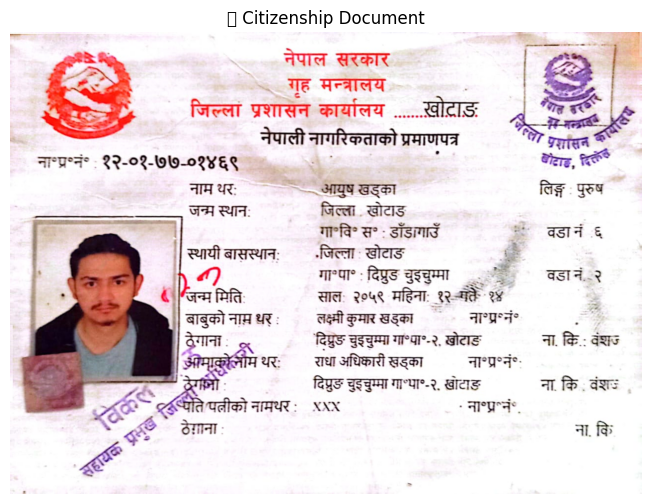

### 📜 OCR Text (Line by Line)

• नेपाली नागरिकताको प्रमाणपत्र परालन
• ना-प्र.्न १२-०१-७७-०१४६९ दोटाङ, दिककै
• नाम थर: आयुष खड्का लिङ्ग पुरुष
• गा-विः स. डाँडागाउँ 5 वडा नं ६
• १ ९ मिति साल २०५९ महिना १२ मंतै १५
• बाबुको नाम थर: लक्ष्मी कुमार खड्का ना-प्र.न न््
• ठेगाना दिपङ चइ्चम्मा गा-पा-२. खोटाङ ना. कि.: वंशज
• थर: राधा अधिकारी खड्का ना.प्र.नं
• ट ठेगानो दिपुङ चुइ्चम्मा गा-पा.-२. खोटाङ ना कि वंश
• ्ट्ठ पत्नीको नामथर : ५५५ ना. प्र.नं


### 🧾 Final Structured Fields

{
    "Citizenship Number": "१२-०१-७७-०१४६९",
    "Full Name": "आयुष खड्का  पुरुष",
    "Gender": "पुरुष",
    "Father's Name": "लक्ष्मी कुमार खड्का न न््",
    "Mother's Name": "",
    "Spouse's Name": "५५५ ना. प्र.नं",
    "Permanent Address": "वंशज",
    "Ward Number": "६",
    "Date of Birth (BS)": "२०५९ महिना १२ मंतै १५",
    "Citizenship Type": "परालन"
}


In [63]:
# Run this in the next cell
result = process_citizenship_image("test.jpg")


In [ ]:
import re

def extract_clean_fields_from_ocr(ocr_lines):
    data = {
        "Citizenship Number": "",
        "Full Name": "",
        "Gender": "",
        "Father's Name": "",
        "Mother's Name": "",
        "Spouse's Name": "",
        "Permanent Address": "",
        "Ward Number": "",
        "Date of Birth (BS)": "",
        "Citizenship Type": ""
    }

    LABEL_MAP = {
        "नाम थर": "Full Name",
        "बाबुको नाम थर": "Father's Name",
        "लिङ्ग": "Gender",
        "ठेगाना": "Permanent Address",
        "गा-पा": "Permanent Address",
        "गा-विः": "Permanent Address",
        "गाउँपालिका": "Permanent Address",
        "वडा नं": "Ward Number",
        "ना-प्र": "Citizenship Number",
        "ना.प्र": "Citizenship Number",
        "साल": "Date of Birth (BS)",
        "मिति": "Date of Birth (BS)",
        "नागरिकताको प्रमाणपत्र": "Citizenship Type"
    }

    def normalize(line):
        return re.sub(r"\s+", " ", line.replace("।", ":").strip())

    def clean_value(val):
        val = re.sub(r'(ना[-\.]प्र\.?|नं|लिङ्ग|नाम थर|बाबुको नाम थर|ठेगाना|मिति|Citizenship Number)', '', val)
        return val.strip(" :-")

    def is_duplicate(value, existing_value):
        return existing_value and (value in existing_value or existing_value in value)

    for line in ocr_lines:
        line = normalize(line)

        if not any(re.search(r'[\u0900-\u097F]', char) for char in line):
            continue  # skip garbage lines with no Devanagari characters

        if "नागरिकताको प्रमाणपत्र" in line and not data["Citizenship Type"]:
            data["Citizenship Type"] = line.split("नागरिकताको प्रमाणपत्र")[-1].strip()
            continue

        # Colon-based detection
        colon_pairs = re.findall(r'([^:]+):\s*([^:]+)', line)
        for raw_label, raw_value in colon_pairs:
            label = raw_label.strip()
            value = clean_value(raw_value.strip())

            for key, mapped_field in LABEL_MAP.items():
                if key in label and mapped_field in data:
                    existing_value = data[mapped_field]
                    if not existing_value or not is_duplicate(value, existing_value):
                        data[mapped_field] = value
                    break

        # DOB fallback
        if not data["Date of Birth (BS)"] and all(k in line for k in ["साल", "महिना", "मंतै"]):
            match = re.search(r'साल\s*(\d{4})\s*महिना\s*(\d{1,2})\s*मंतै\s*(\d{1,2})', line)
            if match:
                y, m, d = match.groups()
                data["Date of Birth (BS)"] = f"{y} महिना {m} मंतै {d}"

        # Citizenship Number fallback
        if not data["Citizenship Number"]:
            match = re.search(r'(\d{2}[-–]\d{2}[-–]\d{2,4}[-–]?\d+)', line)
            if match:
                data["Citizenship Number"] = match.group(1)

        # Gender fallback
        if not data["Gender"]:
            if "पुरुष" in line:
                data["Gender"] = "पुरुष"
            elif "महिला" in line:
                data["Gender"] = "महिला"

        # Ward Number fallback
        if not data["Ward Number"] and "वडा नं" in line:
            match = re.search(r'वडा नं\s*(\d+)', line)
            if match:
                data["Ward Number"] = match.group(1)

        # Permanent Address fallback
        if not data["Permanent Address"] and any(x in line for x in ["दिपुङ", "कन्काई", "ठेगाना"]):
            match = re.search(r'([कन्काई|दिपुङ|ठेगाना].*?)(?:\s*ना|$)', line)
            if match:
                value = clean_value(match.group(1).strip())
                if not is_duplicate(value, data["Permanent Address"]):
                    data["Permanent Address"] = value

    # Final cleanup: remove embedded gender from full name
    if data["Full Name"]:
        if "पुरुष" in data["Full Name"]:
            data["Full Name"] = data["Full Name"].replace("पुरुष", "").replace("लिङ्ग", "").strip()
            if not data["Gender"]:
                data["Gender"] = "पुरुष"
        elif "महिला" in data["Full Name"]:
            data["Full Name"] = data["Full Name"].replace("महिला", "").replace("लिङ्ग", "").strip()
            if not data["Gender"]:
                data["Gender"] = "महिला"
        else:
            data["Full Name"] = data["Full Name"].replace("लिङ्ग", "").strip()

    # ❌ Prevent accidental 'Mother's Name' from single-word 'थर:' lines
    if data["Mother's Name"] and not any([data["Father's Name"], data["Spouse's Name"], data["Full Name"]]):
        if len(data["Mother's Name"].split()) <= 2:
            data["Mother's Name"] = ""

    return data


In [ ]:
from groq import Groq
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import json

# === Step 1: Set your Groq API key ===
os.environ["GROQ_API_KEY"] = "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"  # Replace with your real key

# === Step 2: Initialize Groq Client ===
client = Groq()

# === Step 3: Use your local image (ayush.jpg) ===
local_image_path = "ayush.jpg"

# === Step 4: Upload it somewhere OR use a temporary image link ===
# TEMPORARY HACK: use a placeholder online image until you upload ayush.jpg
# You must replace this with your own uploaded image link of `ayush.jpg`
image_url = "https://www.google.com/url?sa=i&url=https%3A%2F%2Fkathmandupost.com%2Fmiscellaneous%2F2015%2F09%2F08%2Fbhumika-finally-gets-citizenship&psig=AOvVaw22Ts2W-CNZZV8D5uJ4Rc3g&ust=1745158379086000&source=images&cd=vfe&opi=89978449&ved=0CBEQjRxqFwoTCMi-mNuj5IwDFQAAAAAdAAAAABAI"  # Replace with your uploaded 'ayush.jpg' URL

# === Step 5: Send to Groq ===
response = client.chat.completions.create(
    model="meta-llama/llama-4-maverick-17b-128e-instruct",
    messages=[
        {
            "role": "system",
            "content": "Only extract the following information from the image in same language as the original.\nexample:\n{\n  \"full_name\": \"John Doe\",\n  \"date_of_birth\": \"1990-05-15\",\n  \"national_id\": \"A123456789\",\n  \"gender\": \"Male\",\n  \"expiry_date\": \"2030-05-15\",\n  \"address\": \"123 Main Street, Springfield, IL, USA\",\n  \"nationality\": \"American\"\n}"
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": ""
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url
                    }
                }
            ]
        }
    ],
    temperature=1,
    max_tokens=1024,
    top_p=1,
    stream=False
)

# === Step 6: Get result text or JSON ===
json_output_raw = response.choices[0].message.content
try:
    extracted_data = json.loads(json_output_raw)
except:
    extracted_data = json_output_raw

# === Step 7: Display local image and JSON result ===
img = Image.open(local_image_path)

plt.figure(figsize=(12, 6))

# Show image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Local Image: ayush.jpg")

# Show JSON/text
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Extracted Data")

if isinstance(extracted_data, dict):
    json_text = json.dumps(extracted_data, indent=2, ensure_ascii=False)
else:
    json_text = extracted_data

plt.text(0, 1, json_text, ha='left', va='top', wrap=True, fontsize=10, family='monospace')
plt.tight_layout()
plt.show()


SyntaxError: invalid non-printable character U+00A0 (2039889098.py, line 31)